<a href="https://colab.research.google.com/github/atariqbscs/CanvasInsight/blob/master/Detecting_children_emotions_using_FASTAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *
import os
import torch

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'/


In [0]:
path = Path("/gdrive/My Drive/")

In [0]:
for folder in ('Depression', 'Happy'):
    print(folder)
    verify_images(path/folder, delete=True, max_size=500)
            

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [31]:
data.classes

['Depression', 'Happy', 'test']

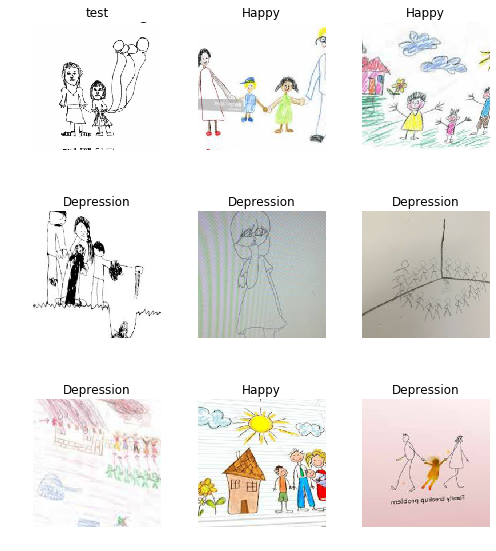

In [32]:
data.show_batch(rows=3, figsize=(7, 8))

In [33]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Depression', 'Happy', 'test'], 3, 256, 64)

In [0]:
from fastai.metrics import error_rate # 1 - accuracy
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [35]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (256 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Depression,Depression,Depression,Depression,Depression
Path: /gdrive/My Drive;

Valid: LabelList (64 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Depression,Happy,Depression,Depression,Depression
Path: /gdrive/My Drive;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64,

In [36]:
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.288739,2.113432,0.812500,00:06
1,1.054929,1.609351,0.546875,00:05
2,0.873160,1.286952,0.406250,00:05
3,0.751226,1.076923,0.390625,00:05


In [0]:
learn.unfreeze()

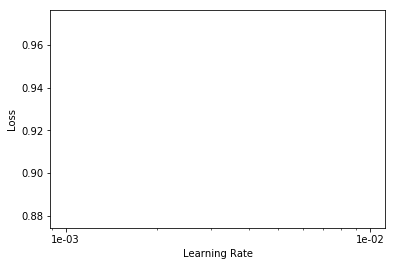

In [40]:
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.468942,1.103234,0.359375,00:06
1,0.448247,1.150614,0.359375,00:05
2,0.390823,1.094987,0.281250,00:06
3,0.355036,0.991953,0.234375,00:06


In [0]:

learn.save('Emotion-detection-stage-1')

In [0]:
from fastai.widgets import *


In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

In [0]:
ImageCleaner(ds, idxs, path)

In [0]:

df = pd.read_csv(path/'cleaned.csv', header='infer')
df.head()

,name,label
0,Depression/download (1).jpg,Depression
1,Depression/download (1).png,Depression
2,Depression/download (12).jpg,Depression
3,Depression/download (13).jpg,Depression
4,Depression/download (11).jpg,Depression


In [0]:
df[(df['name'].apply(lambda x: len(x)<5))]

,name,label


In [0]:
np.random.seed(42)
db = (ImageList.from_df(df, path)
                   .split_by_rand_pct(0.2)
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch(bs=8)).normalize(imagenet_stats)


In [0]:

data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Depression', 'Happy (1)', 'test'], 3, 254, 63)

In [0]:

db.classes, db.c, len(db.train_ds), len(db.valid_ds)

(['Depression', 'Happy (1)'], 2, 200, 49)

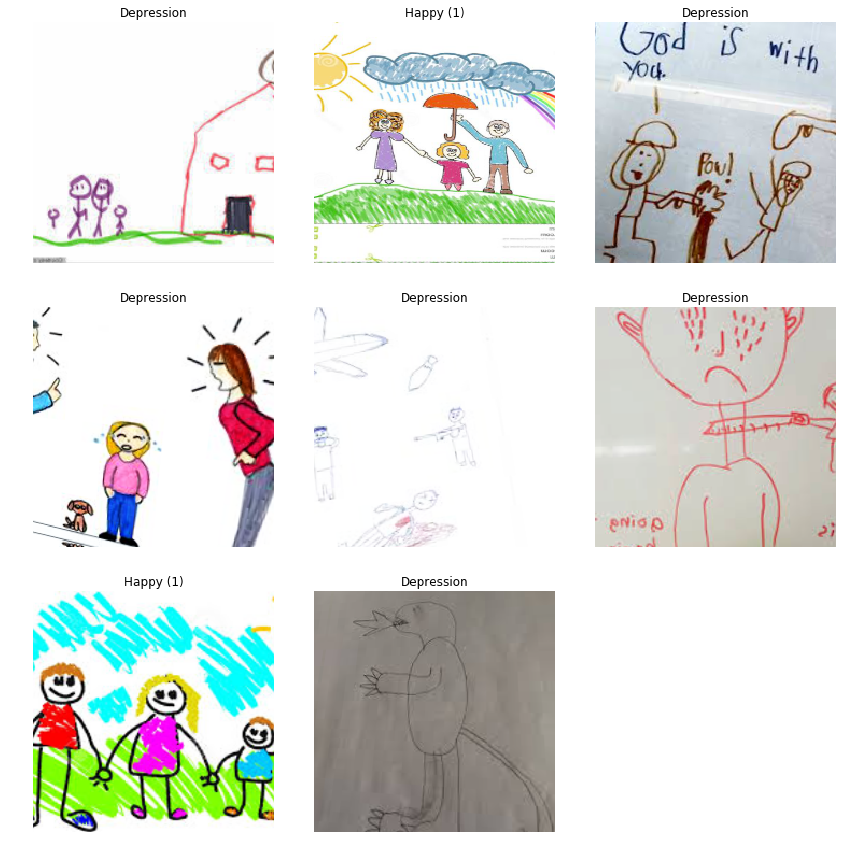

In [0]:
db.show_batch()


In [0]:
learn.data = db

In [0]:
learn.freeze()
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.441184,0.174702,0.040816,00:03
1,0.354489,0.253726,0.081633,00:03
2,0.344258,0.236000,0.040816,00:02
3,0.299155,0.251776,0.081633,00:02


In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


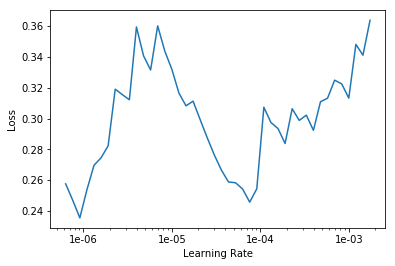

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.317179,0.202794,0.040816,00:02
1,0.432493,0.269001,0.102041,00:03
2,0.430135,0.207271,0.040816,00:03
3,0.322711,0.186534,0.040816,00:03


In [0]:
learn.save('Emotion-detection-stage-2')

In [0]:

interp = ClassificationInterpretation.from_learner(learn)

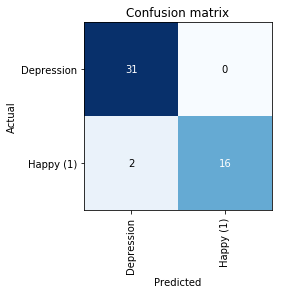

In [0]:
interp.plot_confusion_matrix()

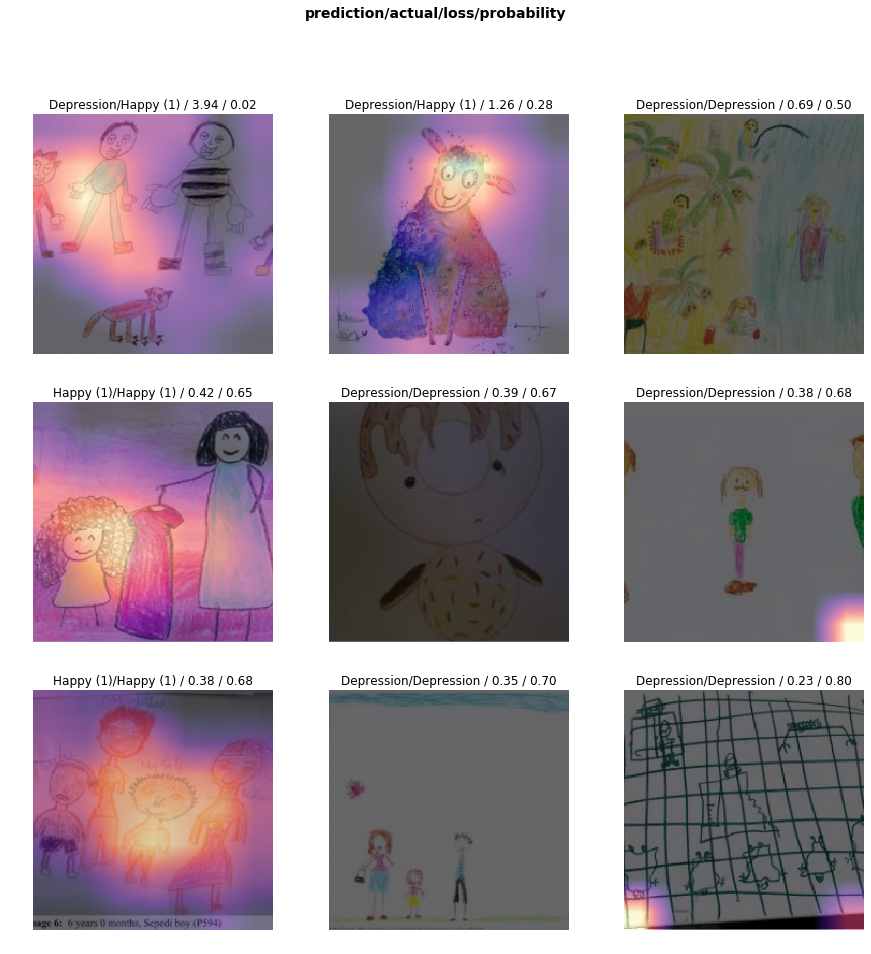

In [0]:
interp.plot_top_losses(9, figsize=(15,15))

In [10]:
learn.load("Emotion-detection-stage-2")

Learner(data=ImageDataBunch;

Train: LabelList (256 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Depression,Depression,Depression,Depression,Depression
Path: /gdrive/My Drive;

Valid: LabelList (64 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Depression,Happy,Depression,Depression,Depression
Path: /gdrive/My Drive;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64,

In [1]:
img=open_image('/gdrive/My Drive/test/test5.jpg')

NameError: ignored

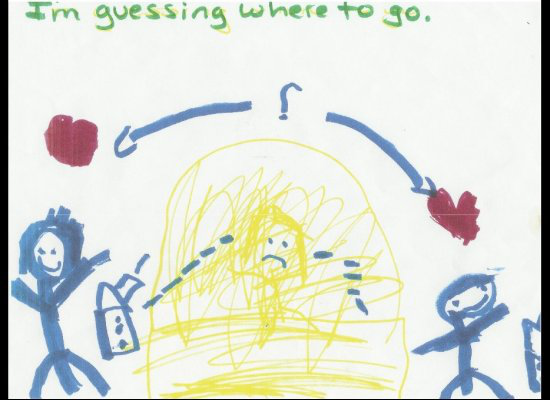

In [25]:
img

In [26]:
learn.predict(img)

(Category Happy, tensor(1), tensor([0.4468, 0.4745, 0.0787]))